# Визуализация экспериментов

In [1]:
import glob
import json
import shutil
import sys

print(sys.version_info)
import os

os.environ["WANDB_CONSOLE"] = "off"
import random
import uuid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
from tqdm.auto import tqdm

sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)


In [2]:
N = np.arange(8, 256)
tau_pos = 0.1
tau_neg = 1 - tau_pos
deb_neg_start = 1 / (N + tau_neg - N * tau_pos)
deb_pos_start = N * tau_pos / (2 - tau_neg) / (2 - tau_neg + N * tau_pos)

deb_neg_end = 1 / (N + (tau_neg - N * tau_pos) * np.exp(1))
deb_pos_end = N * tau_pos * np.exp(1) / (1 + np.exp(1) - tau_neg) / (1 + np.exp(1) - tau_neg + N * tau_pos)

При увеличении N градиент для DebiasedNeg лосса уменьшается. Это объясняется тем, что чем больше элементов в батче, тем меньше влияние ошибки 1го рода?

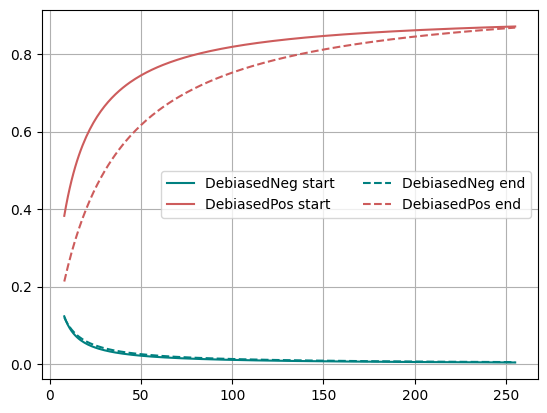

In [3]:
plt.plot(N, deb_neg_start, color="teal", label="DebiasedNeg start")
plt.plot(N, deb_pos_start, color="indianred", label="DebiasedPos start")
plt.plot(N, deb_neg_end, color="teal", linestyle="--", label="DebiasedNeg end")
plt.plot(N, deb_pos_end, color="indianred", linestyle="--", label="DebiasedPos end")
plt.legend(ncol=2)
plt.grid()
plt.show()

In [4]:
api = wandb.Api()
root = "/home/asciishell/s3/jupyter.asciishell.ru"
path_config = f"{root}/logs/config/{{}}.json"
path_metrics = f"{root}/logs/metrics/{{}}.json"

In [5]:
runs_ = api.runs("mlao/chingyaoc-dcl")
runs = [x for x in runs_ if "protected" in x.tags]
len(runs)

62

In [6]:
runs = {x.config["uuid"]: x for x in runs}

In [7]:
len(runs), len(set(runs))

(62, 62)

In [8]:
exp_df = []
for uuid_ in runs:
    out = path_config.format(uuid_)
    if not os.path.exists(out):
        continue
    with open(out, "rb") as f:
        js = json.load(f)
        exp_df.append(js)

In [9]:
exp_df = pd.DataFrame(exp_df).fillna(0)

In [10]:
exp_df.drop(index=exp_df[exp_df["loss"] == "DebiasedPos"].index, inplace=True)
exp_df.replace({"DebiasedPosV2": "DebiasedPos"}, inplace=True)

In [11]:
exp_df.head(3)

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
0,200,0.001,Combination,92033775-e1a3-4ca4-a74f-8431c20acc54,resnet50,200,CIFAR10,False,1,0.1,64,0.10,loss_combination,0.0,128,0.5,0.000001
1,200,0.001,Combination,f87c87df-7c45-4664-bb9b-20a08dafdce8,resnet50,200,CIFAR10,False,1,0.1,64,0.05,loss_combination,0.0,128,0.5,0.000001
2,200,0.001,Combination,b568282a-2d89-4302-bb26-629d63994ab8,resnet50,200,CIFAR10,False,1,0.1,64,0.25,loss_combination,0.0,128,0.5,0.000001


In [12]:
exp_df["num_pos"].value_counts()

1    37
2     9
8     4
4     4
Name: num_pos, dtype: int64

In [13]:
exp_df[exp_df["num_pos"] == 2]

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
18,200,0.001,DebiasedNeg,f95a1e3d-9240-4d10-9608-982cc26f5f55,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
19,200,0.001,DebiasedNeg,2edc9233-89db-4e23-b18a-990e76100f6c,resnet50,200,CIFAR10,True,2,0.1,64,0.0,pos_grouping,0.0,128,0.5,0.000001
20,200,0.001,DebiasedPos,43eaab07-6655-4f96-9048-30542d3e28d7,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
21,200,0.001,Contrastive,95fa78e9-6c62-494d-bfa4-173f0601e7f8,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
22,200,0.001,Contrastive,35116b37-823b-4a1b-b638-0077a8926445,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
23,200,0.001,DebiasedNeg,41b0aaf1-9456-41dd-b72f-8cfd4ba05a4d,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
24,200,0.001,DebiasedPos,191f92b9-931a-4f34-b122-6792c5744a65,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
39,200,0.001,DebiasedNeg,8dcbfe35-f27f-462a-a09a-d359c6ceb2cd,resnet50,200,CIFAR10,False,2,0.1,64,0.0,pos_grouping,0.1,128,0.5,0.000001
42,200,0.001,DebiasedNeg,e73e8c3e-bb87-4845-ade5-19c7fb8f3f82,resnet50,200,CIFAR10,False,2,0.1,64,0.0,pos_grouping,0.0,128,0.5,0.000001


In [14]:
exp_df["loss_neg_w"].value_counts()

0.00    50
0.10     1
0.05     1
0.25     1
0.75     1
Name: loss_neg_w, dtype: int64

In [15]:
def get_metrics(uuid):
    out = path_metrics.format(uuid)
    if not os.path.exists(out):
        return {}
    with open(out, "rb") as f:
        js = json.load(f)
    return pd.DataFrame(js)

In [16]:
colors_map = {"DebiasedPos": "indianred", "DebiasedNeg": "teal", "Contrastive": "peru"}

In [17]:
base_dict = {
    "model": "resnet50",
    "dataset": "CIFAR10",
    "drop_fn": False,
    "num_pos": 1,
    "tau_plus": 0.1,
    "loss_neg_w": 0,
    "batch_size": 64,
    "m_agg_mode": "loss_combination",
    "noise_frac": 0,
    "lr": 0.001,
}
x = exp_df.copy()
for k, v in base_dict.items():
    x = x[x[k] == v].copy()
# base_df = x.drop(columns=list(base_dict.keys())).copy()
base_df = x.sort_values("loss").copy()
base_df

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
45,200,0.001,Contrastive,857628f3-a7c7-4b4c-84dc-ef0315287d11,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
44,200,0.001,DebiasedNeg,976bd88c-44a6-42a1-8d61-38e37103d753,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
35,200,0.001,DebiasedPos,f92ba8f8-25d4-4ae1-b0ab-799a36ec7bed,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


## Эксперимент: base VS lr=0.0005

In [18]:
new_dict = base_dict.copy()
new_dict["lr"] = 0.0005

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
5,200,0.0005,DebiasedNeg,5387edce-1b30-4d16-b243-40239c463832,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
6,200,0.0005,DebiasedPos,438ccd79-8826-4774-b58c-29745e8f4d9f,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


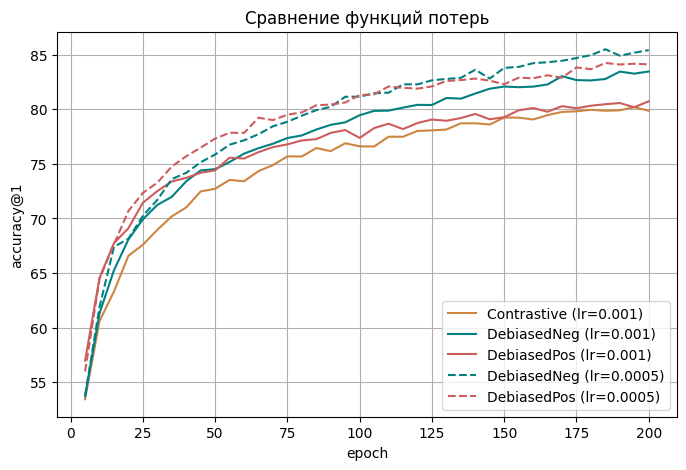

In [19]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (lr=0.001)", color=colors_map[row["loss"]])

for i, row in new_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (lr=0.0005)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь")
plt.grid()

plt.savefig("images/exp_base.png", bbox_inches="tight")
plt.show()

## Эксперимент: base VS Drop FN = True
Сравниваем все лоссы. Хотим убедиться, что (1) исключение ошибки 1го рода (FN) улучшает качество моделей и (2) для Drop FN = True Debiased Pos лучше Contrastive и Debiased Neg? 

In [20]:
new_dict = base_dict.copy()
new_dict["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
41,200,0.001,Contrastive,7bd9f783-0f8f-446a-aa08-8e011d08eef3,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
38,200,0.001,DebiasedNeg,d7ca6f2d-627a-4f88-9800-cc36654d3e21,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
34,200,0.001,DebiasedPos,95906880-716b-4c72-8c79-022baa101109,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


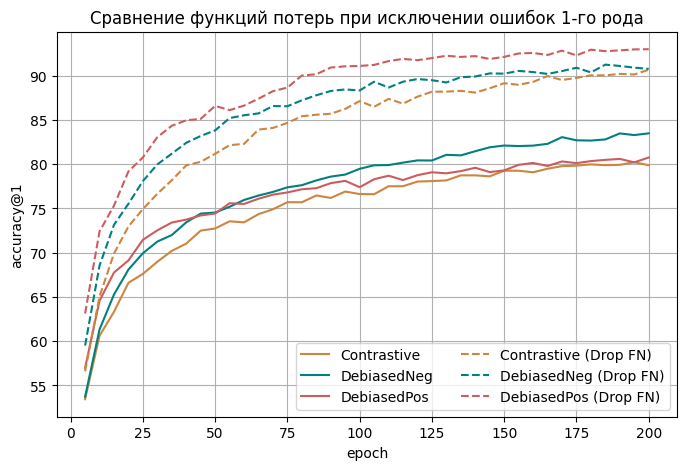

In [21]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (Drop FN)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при исключении ошибок 1-го рода")
plt.grid()

plt.savefig("images/exp_base_vs_dropfn.png", bbox_inches="tight")
plt.show()

- Ранжирование лоссов меняется. Предлагаемый лосс работает лучше остальных в случае исключения ошибок 1го рода (ложно отрицательные). 
- Между contrastive и debiasedNeg при исключении ошибок 1го рода различия практически нет на последних эпохах. 
- Аналогично нет разницы между contrastive и debiasedPos в исходном (базовом) эксперименте

Про базовый график:
- на ранних эпохах debiasedPos показывает себя лучше. Его можно использовать для инициализации, прогрева на первых эпохах

## Эксперимент: base VS Nose=True or/and Drop FN = True
Сравниваем все лоссы. Ожидаем, что (исключение ошибки 1го рода (FN) и/или) добавление ошибки 2го рода (FP), т.е. ухудшение датасета, может быть митигированно Debiased Pos лоссом

### base VS Nose=True

In [22]:
new_dict = base_dict.copy()
new_dict["noise_frac"] = 0.1

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_1 = x.sort_values("loss").copy()
new_df_1

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
50,200,0.001,Contrastive,d89b0b43-a8f6-4f87-9f89-c00178830809,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001
49,200,0.001,DebiasedNeg,95468ad7-47a7-437f-a48d-8cb763ce7b8d,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001
32,200,0.001,DebiasedPos,f160039c-5934-44fa-bdcf-f5c7b27b6cf2,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001


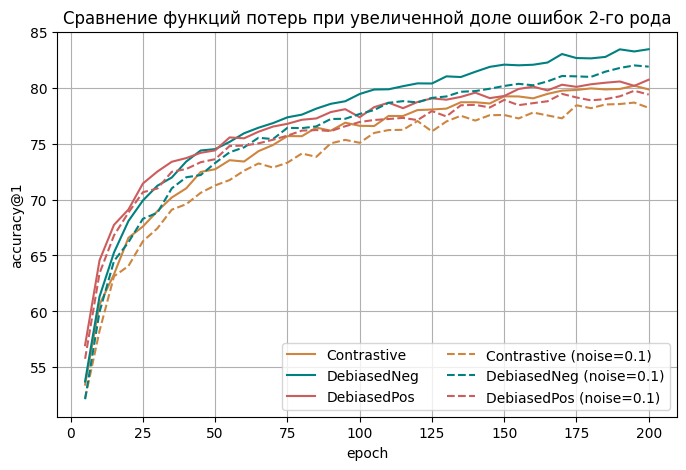

In [23]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df_1.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (noise=0.1)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при увеличенной доле ошибок 2-го рода")
plt.grid()

plt.savefig("images/exp_base_vs_noise01.png", bbox_inches="tight")
plt.show()

- Зашумление датасета (увеличение доли ошибок 2го рода - ложно положительных) ухудшает качество обучения 
- Для debiasedPos падение качества меньше (на всем периоде обучения)

In [24]:
new_dict = base_dict.copy()
new_dict["noise_frac"] = 0.3

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_3 = x.sort_values("loss").copy()
new_df_3

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
25,200,0.001,Contrastive,25a94d26-8eef-49c0-9a7d-3c5f3399ea27,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.3,128,0.5,0.000001
27,200,0.001,DebiasedNeg,c3999b91-1cd6-4f65-a956-42116231ceaf,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.3,128,0.5,0.000001
26,200,0.001,DebiasedPos,1ca9c179-970d-42bf-a184-e578f1a9aa9c,resnet50,200,CIFAR10,False,1,0.1,64,0.0,loss_combination,0.3,128,0.5,0.000001


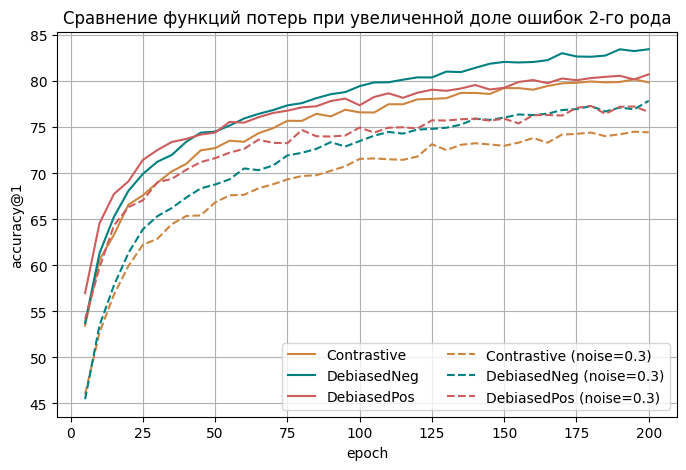

In [25]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df_3.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (noise=0.3)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при увеличенной доле ошибок 2-го рода")
plt.grid()

plt.savefig("images/exp_base_vs_noise03.png", bbox_inches="tight")
plt.show()

При сильном зашумлении (даже без исключени ошибок 1го рода) debiasedPos и debiasedNeg находятся в паритете. 
При этом на ранних эпохах debiasedPos все еще лучше.

Т.е. исправление ошибки 2го рода с помощью debiasedPos равноценно исправлению ошибки 1го рода с помощью debiasedNeg, если в датасете присутствуют и ошибки 1го, и ошибки 2го рода. (В данном случае доля ошибок 2го роды выше)

In [26]:
def get_last_acc1(df):
    res = []
    for i, row in df.iterrows():
        m = get_metrics(row["uuid"])
        if len(m):
            m = m[m["epoch"] == m["epoch"].max()]["loss/acc1"]
            res.append(m.values[0])
    return np.array(res)

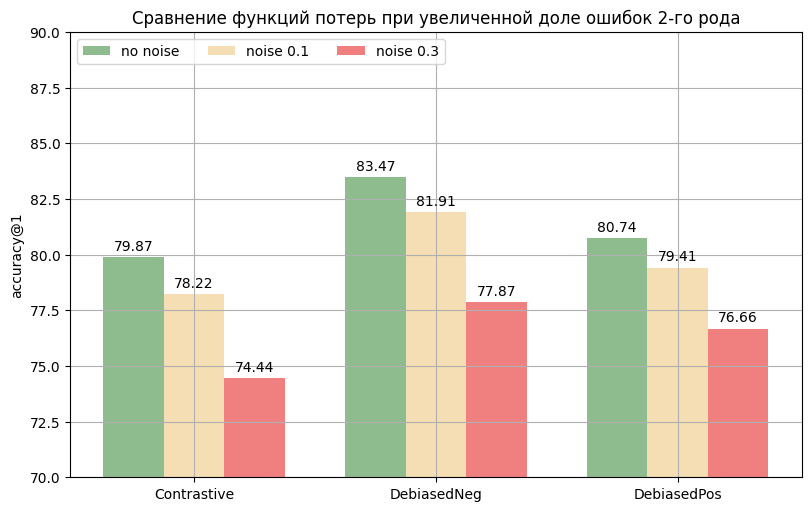

In [27]:
losses = ("Contrastive", "DebiasedNeg", "DebiasedPos")
noise_acc = {
    "no noise": get_last_acc1(base_df),
    "noise 0.1": get_last_acc1(new_df_1),
    "noise 0.3": get_last_acc1(new_df_3),
}

x = np.arange(len(losses))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))

for (attribute, measurement), color in zip(noise_acc.items(), ["darkseagreen", "wheat", "lightcoral"]):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("accuracy@1")
ax.set_title("Сравнение функций потерь при увеличенной доле ошибок 2-го рода")
ax.set_xticks(x + width, losses)
ax.legend(loc="upper left", ncols=3)
ax.set_ylim(70, 90)

plt.grid()

plt.savefig("images/exp_base_vs_noise0103.png", bbox_inches="tight")
plt.show()

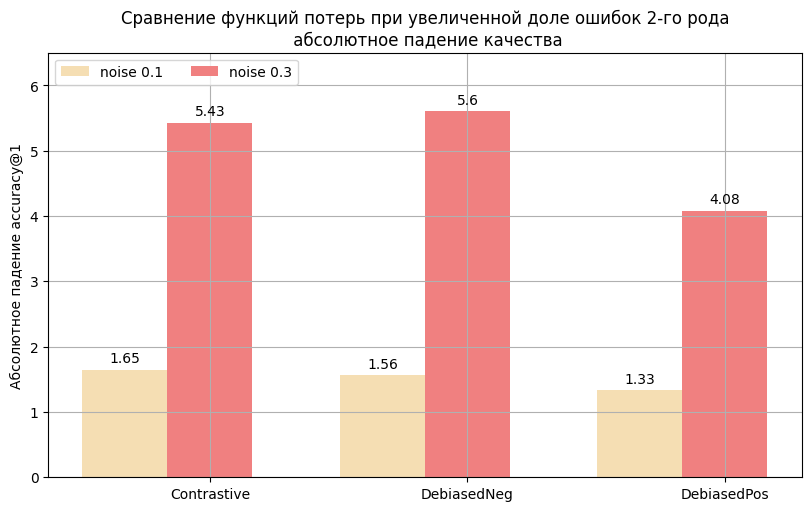

In [28]:
losses = ("Contrastive", "DebiasedNeg", "DebiasedPos")
noise_acc = {
    "noise 0.1": get_last_acc1(base_df) - get_last_acc1(new_df_1),
    "noise 0.3": get_last_acc1(base_df) - get_last_acc1(new_df_3),
}

x = np.arange(len(losses))
width = 0.33
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))

for (attribute, measurement), color in zip(noise_acc.items(), ["wheat", "lightcoral"]):
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 2), width, label=attribute, color=color)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Абсолютное падение accuracy@1")
ax.set_title("Сравнение функций потерь при увеличенной доле ошибок 2-го рода\n абсолютное падение качества")
ax.set_xticks(x + width, losses)
ax.legend(loc="upper left", ncols=2)
ax.set_ylim(0, 6.5)

plt.grid()

plt.savefig("images/exp_base_vs_noise0103abs.png", bbox_inches="tight")
plt.show()

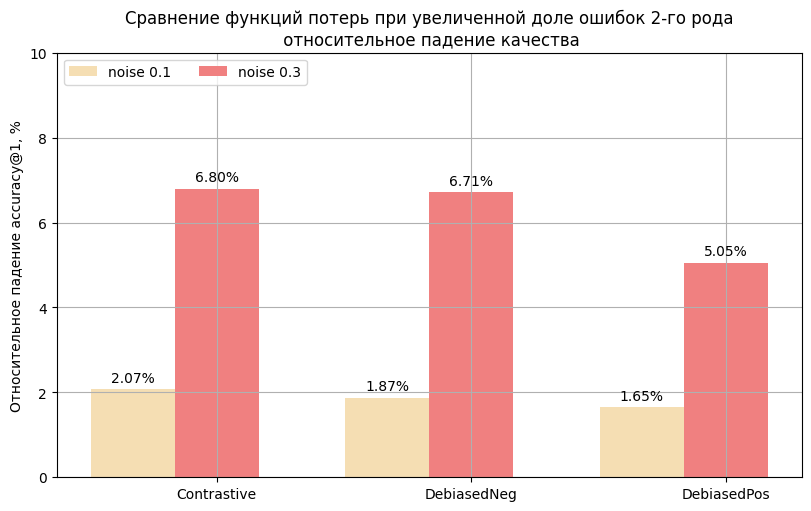

In [29]:
losses = ("Contrastive", "DebiasedNeg", "DebiasedPos")
noise_acc = {
    "noise 0.1": (get_last_acc1(base_df) - get_last_acc1(new_df_1)) / get_last_acc1(base_df),
    "noise 0.3": (get_last_acc1(base_df) - get_last_acc1(new_df_3)) / get_last_acc1(base_df),
}

x = np.arange(len(losses))
width = 0.33
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))

for (attribute, measurement), color in zip(noise_acc.items(), ["wheat", "lightcoral"]):
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 4) * 100, width, label=attribute, color=color)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Относительное падение accuracy@1, %")
ax.set_title("Сравнение функций потерь при увеличенной доле ошибок 2-го рода\n относительное падение качества")
ax.set_xticks(x + width, losses)
ax.legend(loc="upper left", ncols=2)
ax.set_ylim(0, 10)

for p in ax.containers:
    ax.bar_label(p, fmt="%.2f%%", label_type="edge", padding=3)

plt.grid()

plt.savefig("images/exp_base_vs_noise0103rel.png", bbox_inches="tight")
plt.show()

### base VS Nose=True and Drop FN = True

In [30]:
new_dict = base_dict.copy()
new_dict["noise_frac"] = 0.1
new_dict["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
36,200,0.001,Contrastive,3e54bb51-d54b-4afa-b97b-6d97d574f300,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001
37,200,0.001,DebiasedNeg,269322aa-b068-4f00-99b1-206e8a2d96bb,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001
33,200,0.001,DebiasedPos,133c2dc1-dc3b-446a-85f0-1cc64542aa5d,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001


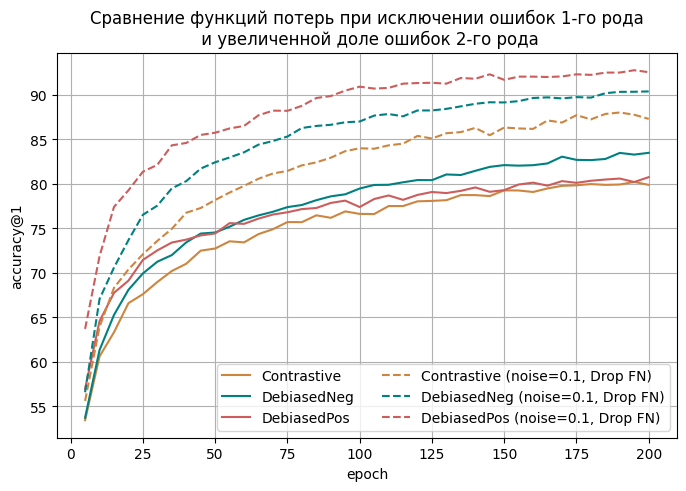

In [31]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"],
        m["loss/acc1"],
        label=row["loss"] + " (noise=0.1, Drop FN)",
        color=colors_map[row["loss"]],
        linestyle="--",
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при исключении ошибок 1-го рода\n и увеличенной доле ошибок 2-го рода")
plt.grid()
plt.savefig("images/exp_base_vs_noise01_dropfn.png", bbox_inches="tight")
plt.show()

Не особо полезный график, просто показывает улучшение. Насколько влияет шум - ниже

### Drop FN = True VS Nose=True and Drop FN = True

In [32]:
new_dict_1 = base_dict.copy()
new_dict_1["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict_1.items():
    x = x[x[k] == v].copy()
new_dict_1 = x.sort_values("loss").copy()
new_dict_1

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
41,200,0.001,Contrastive,7bd9f783-0f8f-446a-aa08-8e011d08eef3,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
38,200,0.001,DebiasedNeg,d7ca6f2d-627a-4f88-9800-cc36654d3e21,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
34,200,0.001,DebiasedPos,95906880-716b-4c72-8c79-022baa101109,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


In [33]:
new_dict_2 = base_dict.copy()
new_dict_2["noise_frac"] = 0.1
new_dict_2["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict_2.items():
    x = x[x[k] == v].copy()
new_dict_2 = x.sort_values("loss").copy()
new_dict_2

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
36,200,0.001,Contrastive,3e54bb51-d54b-4afa-b97b-6d97d574f300,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001
37,200,0.001,DebiasedNeg,269322aa-b068-4f00-99b1-206e8a2d96bb,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001
33,200,0.001,DebiasedPos,133c2dc1-dc3b-446a-85f0-1cc64542aa5d,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.1,128,0.5,0.000001


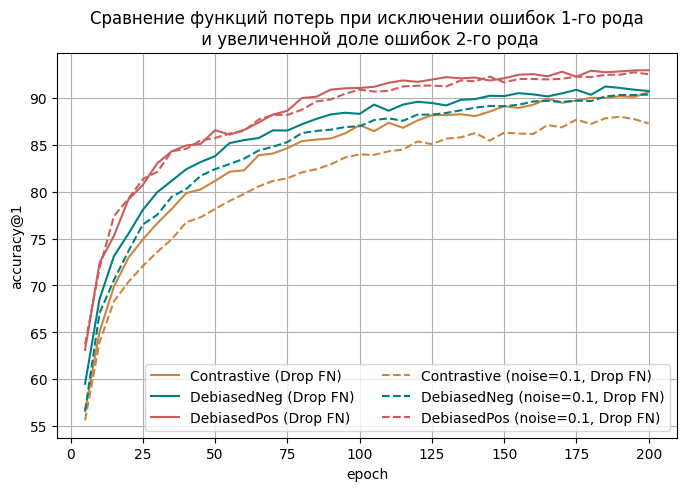

In [34]:
plt.figure(figsize=(8, 5))
for i, row in new_dict_1.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (Drop FN)", color=colors_map[row["loss"]])

for i, row in new_dict_2.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"],
        m["loss/acc1"],
        label=row["loss"] + " (noise=0.1, Drop FN)",
        color=colors_map[row["loss"]],
        linestyle="--",
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при исключении ошибок 1-го рода\n и увеличенной доле ошибок 2-го рода")
plt.grid()
plt.savefig("images/exp_dropfn_vs_noise01_dropfn.png", bbox_inches="tight")
plt.show()

Если в датасете отсутствуют ошибки 1го рода и присутствует зашумление ошибками 2го рода, то качество падает незначительно для debiasedPos и debiasedNeg

Для contrastive падение сильное 

## Эксперимент: M=2 

### base VS M=2 (loss_combination)

Сравниваем все лоссы. Хотим убедиться, что увеличение M положительно влияет на качество. Хотим посмотреть, как изменится ранжирование лоссов при новом параметре.

In [35]:
new_dict_2 = base_dict.copy()
new_dict_2["num_pos"] = 2

x = exp_df.copy()
for k, v in new_dict_2.items():
    x = x[x[k] == v].copy()
new_df_2 = x.sort_values("loss").copy()
new_df_2

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
22,200,0.001,Contrastive,35116b37-823b-4a1b-b638-0077a8926445,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
23,200,0.001,DebiasedNeg,41b0aaf1-9456-41dd-b72f-8cfd4ba05a4d,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
24,200,0.001,DebiasedPos,191f92b9-931a-4f34-b122-6792c5744a65,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


In [36]:
new_dict_4 = base_dict.copy()
new_dict_4["num_pos"] = 4

x = exp_df.copy()
for k, v in new_dict_4.items():
    x = x[x[k] == v].copy()
new_df_4 = x.sort_values("loss").copy()
new_df_4

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
14,200,0.001,Contrastive,a28ea4cd-8a65-4630-b605-f016bf327139,resnet50,200,CIFAR10,False,4,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
16,200,0.001,DebiasedNeg,47a04413-e7f8-4896-b7b4-aab8a98b4a96,resnet50,200,CIFAR10,False,4,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
15,200,0.001,DebiasedPos,8112063c-3199-4ac2-8a13-e90853776afe,resnet50,200,CIFAR10,False,4,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


In [37]:
new_dict_8 = base_dict.copy()
new_dict_8["num_pos"] = 8

x = exp_df.copy()
for k, v in new_dict_8.items():
    x = x[x[k] == v].copy()
new_df_8 = x.sort_values("loss").copy()
new_df_8

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
11,200,0.001,Contrastive,2e7e7626-13bb-4812-87bc-d211f37154c9,resnet50,200,CIFAR10,False,8,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
10,200,0.001,DebiasedNeg,b11a1db8-5fbf-400b-a382-7656694493a9,resnet50,200,CIFAR10,False,8,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
12,200,0.001,DebiasedPos,0dd74faf-0604-4aff-8ec0-03402471e135,resnet50,200,CIFAR10,False,8,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


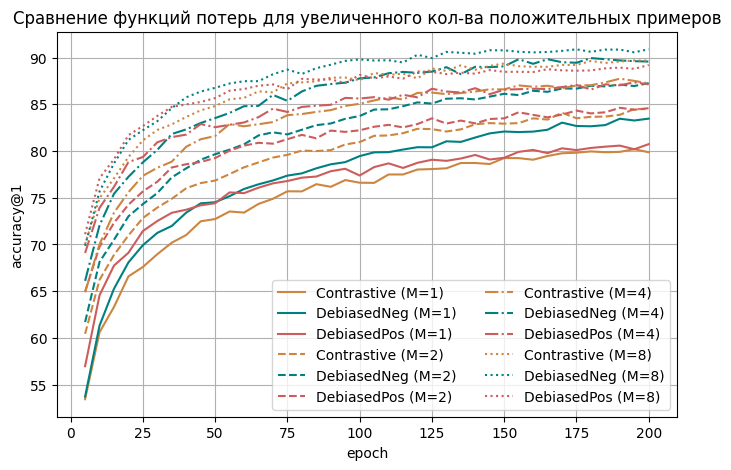

In [38]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    if len(m):
        plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=1)", color=colors_map[row["loss"]])

for i, row in new_df_2.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=2)", color=colors_map[row["loss"]], linestyle="--")

for i, row in new_df_4.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=4)", color=colors_map[row["loss"]], linestyle="-.")

for i, row in new_df_8.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=8)", color=colors_map[row["loss"]], linestyle=":")

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь для увеличенного кол-ва положительных примеров")
plt.grid()
plt.savefig("images/exp_base_vs_loss_combination24.png", bbox_inches="tight")
plt.show()

Увеличение кол-ва положительных примеров улучшает качество. Ранжирование лоссов поменялось: contrastive стал лучше debiasedPos

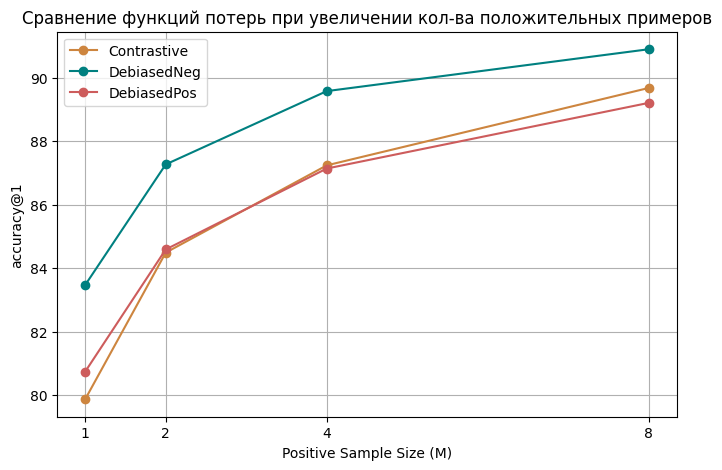

In [39]:
losses = ("Contrastive", "DebiasedNeg", "DebiasedPos")
m = [1, 2, 4, 8]
m_acc = np.array(
    [
        get_last_acc1(base_df),
        get_last_acc1(new_df_2),
        get_last_acc1(new_df_4),
        get_last_acc1(new_df_8),
    ]
)

plt.figure(figsize=(8, 5))
for i in range(len(losses)):
    plt.plot(m, m_acc[:, i], color=colors_map[losses[i]], marker="o", label=losses[i])

plt.xticks(m, m)
plt.legend()
plt.xlabel("Positive Sample Size (M)")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при увеличении кол-ва положительных примеров")
plt.grid()
plt.savefig("images/exp_base_vs_m124.png", bbox_inches="tight")
plt.show()

### M=2 (loss_combination) VS M=2 (loss_combination) and DropFn=True

In [40]:
new_dict_1 = base_dict.copy()
new_dict_1["num_pos"] = 2

x = exp_df.copy()
for k, v in new_dict_1.items():
    x = x[x[k] == v].copy()
new_df_1 = x.sort_values("loss").copy()
new_df_1

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
22,200,0.001,Contrastive,35116b37-823b-4a1b-b638-0077a8926445,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
23,200,0.001,DebiasedNeg,41b0aaf1-9456-41dd-b72f-8cfd4ba05a4d,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
24,200,0.001,DebiasedPos,191f92b9-931a-4f34-b122-6792c5744a65,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


In [41]:
new_dict_2 = base_dict.copy()
new_dict_2["num_pos"] = 2
new_dict_2["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict_2.items():
    x = x[x[k] == v].copy()
new_df_2 = x.sort_values("loss").copy()
new_df_2

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
21,200,0.001,Contrastive,95fa78e9-6c62-494d-bfa4-173f0601e7f8,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
18,200,0.001,DebiasedNeg,f95a1e3d-9240-4d10-9608-982cc26f5f55,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
20,200,0.001,DebiasedPos,43eaab07-6655-4f96-9048-30542d3e28d7,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


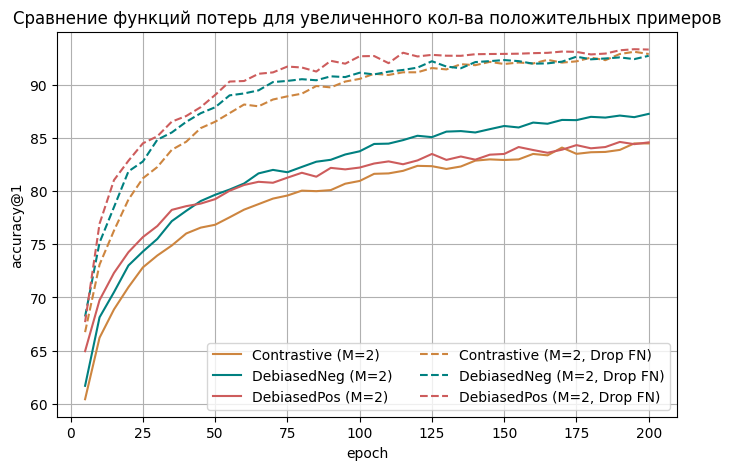

In [42]:
plt.figure(figsize=(8, 5))
for i, row in new_df_1.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=2)", color=colors_map[row["loss"]])

for i, row in new_df_2.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=2, Drop FN)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь для увеличенного кол-ва положительных примеров")
plt.grid()
plt.savefig("images/exp_loss_combination2_vs_loss_combination2_dropfn.png", bbox_inches="tight")
plt.show()

Ниже более информативный график

### M=1 and DropFn=True VS M=2 (loss_combination) and DropFn=True

In [43]:
new_dict_1 = base_dict.copy()
new_dict_1["num_pos"] = 1
new_dict_1["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict_1.items():
    x = x[x[k] == v].copy()
new_df_1 = x.sort_values("loss").copy()
new_df_1

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
41,200,0.001,Contrastive,7bd9f783-0f8f-446a-aa08-8e011d08eef3,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
38,200,0.001,DebiasedNeg,d7ca6f2d-627a-4f88-9800-cc36654d3e21,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
34,200,0.001,DebiasedPos,95906880-716b-4c72-8c79-022baa101109,resnet50,200,CIFAR10,True,1,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


In [44]:
new_dict_2 = base_dict.copy()
new_dict_2["num_pos"] = 2
new_dict_2["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict_2.items():
    x = x[x[k] == v].copy()
new_df_2 = x.sort_values("loss").copy()
new_df_2

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
21,200,0.001,Contrastive,95fa78e9-6c62-494d-bfa4-173f0601e7f8,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
18,200,0.001,DebiasedNeg,f95a1e3d-9240-4d10-9608-982cc26f5f55,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001
20,200,0.001,DebiasedPos,43eaab07-6655-4f96-9048-30542d3e28d7,resnet50,200,CIFAR10,True,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


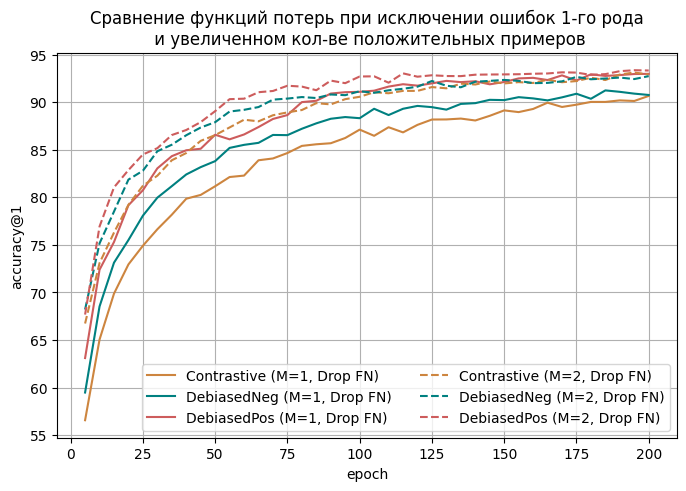

In [45]:
plt.figure(figsize=(8, 5))
for i, row in new_df_1.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=1, Drop FN)", color=colors_map[row["loss"]])

for i, row in new_df_2.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=2, Drop FN)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при исключении ошибок 1-го рода\n и увеличенном кол-ве положительных примеров")
plt.grid()
plt.savefig("images/exp_dropfn_vs_loss_combination2_dropfn.png", bbox_inches="tight")
plt.show()

При исключении ошибок 1го рода увеличение M не влияет на debiasedPos, при исключении ошибок 1го рода и M=2 лоссы равны между собой

### M=2 (loss_combination) VS M=2 (pos_grouping) для DebiasedNeg
Только для DebiasedNeg. Хотим увидеть, какой способ добавления M работает лучше

In [46]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 2
new_dict["m_agg_mode"] = "pos_grouping"
new_dict["loss"] = "DebiasedNeg"

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_2g = x.sort_values("loss").copy()
new_df_2g

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
42,200,0.001,DebiasedNeg,e73e8c3e-bb87-4845-ade5-19c7fb8f3f82,resnet50,200,CIFAR10,False,2,0.1,64,0.0,pos_grouping,0.0,128,0.5,0.000001


In [47]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 2
new_dict["m_agg_mode"] = "loss_combination"
new_dict["loss"] = "DebiasedNeg"

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_2c = x.sort_values("loss").copy()
new_df_2c

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
23,200,0.001,DebiasedNeg,41b0aaf1-9456-41dd-b72f-8cfd4ba05a4d,resnet50,200,CIFAR10,False,2,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


In [48]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 4
new_dict["m_agg_mode"] = "pos_grouping"
new_dict["loss"] = "DebiasedNeg"

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_4g = x.sort_values("loss").copy()
new_df_4g

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
17,200,0.001,DebiasedNeg,6be073a3-4e26-4b4f-ad9e-d12f6877fd6b,resnet50,200,CIFAR10,False,4,0.1,64,0.0,pos_grouping,0.0,128,0.5,0.000001


In [49]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 4
new_dict["m_agg_mode"] = "loss_combination"
new_dict["loss"] = "DebiasedNeg"

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_4c = x.sort_values("loss").copy()
new_df_4c

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
16,200,0.001,DebiasedNeg,47a04413-e7f8-4896-b7b4-aab8a98b4a96,resnet50,200,CIFAR10,False,4,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


In [50]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 8
new_dict["m_agg_mode"] = "pos_grouping"
new_dict["loss"] = "DebiasedNeg"

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_8g = x.sort_values("loss").copy()
new_df_8g

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
13,200,0.001,DebiasedNeg,ab81f4d4-14c1-4db8-a088-de177a108405,resnet50,200,CIFAR10,False,8,0.1,64,0.0,pos_grouping,0.0,128,0.5,0.000001


In [51]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 8
new_dict["m_agg_mode"] = "loss_combination"
new_dict["loss"] = "DebiasedNeg"

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_8c = x.sort_values("loss").copy()
new_df_8c

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
10,200,0.001,DebiasedNeg,b11a1db8-5fbf-400b-a382-7656694493a9,resnet50,200,CIFAR10,False,8,0.1,64,0.0,loss_combination,0.0,128,0.5,0.000001


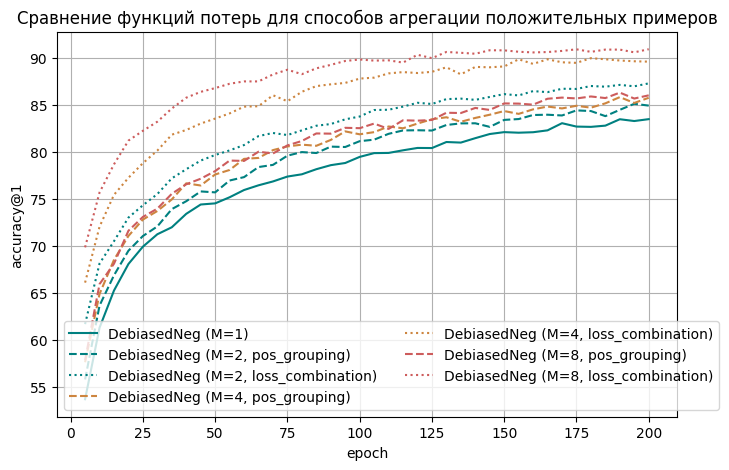

In [52]:
plt.figure(figsize=(8, 5))
for i, row in base_df[base_df["loss"] == "DebiasedNeg"].iterrows():
    m = get_metrics(row["uuid"])
    if len(m):
        plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=1)", color=colors_map[row["loss"]])

for i, row in new_df_2g.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"],
        m["loss/acc1"],
        label=row["loss"] + " (M=2, pos_grouping)",
        color=colors_map[row["loss"]],
        linestyle="--",
    )

for i, row in new_df_2c.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"],
        m["loss/acc1"],
        label=row["loss"] + " (M=2, loss_combination)",
        color=colors_map[row["loss"]],
        linestyle=":",
    )

for i, row in new_df_4g.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=4, pos_grouping)", color="peru", linestyle="--")

for i, row in new_df_4c.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=4, loss_combination)", color="peru", linestyle=":")

for i, row in new_df_8g.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=8, pos_grouping)", color="indianred", linestyle="--")

for i, row in new_df_8c.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=8, loss_combination)", color="indianred", linestyle=":"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь для способов агрегации положительных примеров")
plt.grid()
plt.savefig("images/exp_neg_vs_loss_combination24_vs_pos_grouping248.png", bbox_inches="tight")
plt.show()

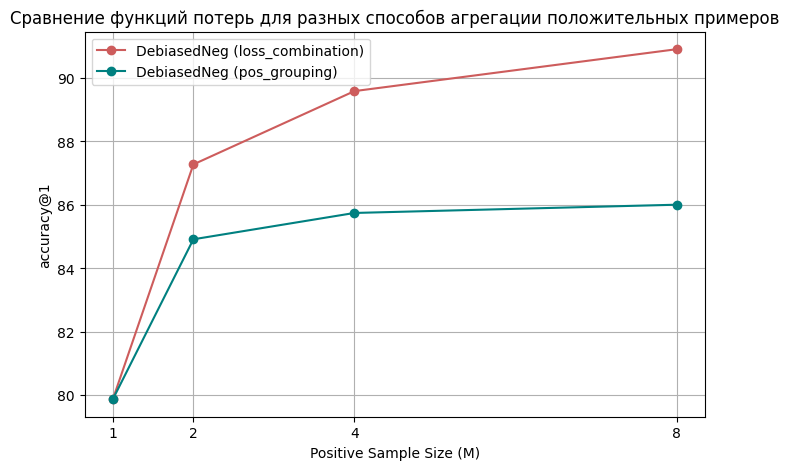

In [53]:
agg_types = ("loss_combination", "pos_grouping")
m = [1, 2, 4, 8]
m_acc = np.array(
    [
        [
            get_last_acc1(base_df)[0],
            get_last_acc1(new_df_2c)[0],
            get_last_acc1(new_df_4c)[0],
            get_last_acc1(new_df_8c)[0],
        ],
        [
            get_last_acc1(base_df)[0],
            get_last_acc1(new_df_2g)[0],
            get_last_acc1(new_df_4g)[0],
            get_last_acc1(new_df_8g)[0],
        ],
    ]
)

plt.figure(figsize=(8, 5))
for i in range(len(agg_types)):
    plt.plot(m, m_acc[i], color=list(colors_map.values())[i], marker="o", label=f"DebiasedNeg ({agg_types[i]})")

plt.xticks(m, m)
plt.legend()
plt.xlabel("Positive Sample Size (M)")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь для разных способов агрегации положительных примеров")
plt.grid()
plt.savefig("images/exp_neg_vs_m124.png", bbox_inches="tight")
plt.show()

Агрегация лоссов лучше бустит качество, чем предлагаемый в статье способ

## Эксперимент: комбинация Pos и Neg

In [54]:
new_dict = base_dict.copy()
new_dict["loss"] = "Combination"
# new_dict["loss_neg_w"] = 0.25
new_dict.pop("loss_neg_w", None)

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
0,200,0.001,Combination,92033775-e1a3-4ca4-a74f-8431c20acc54,resnet50,200,CIFAR10,False,1,0.1,64,0.10,loss_combination,0.0,128,0.5,0.000001
1,200,0.001,Combination,f87c87df-7c45-4664-bb9b-20a08dafdce8,resnet50,200,CIFAR10,False,1,0.1,64,0.05,loss_combination,0.0,128,0.5,0.000001
2,200,0.001,Combination,b568282a-2d89-4302-bb26-629d63994ab8,resnet50,200,CIFAR10,False,1,0.1,64,0.25,loss_combination,0.0,128,0.5,0.000001
3,200,0.001,Combination,99e23260-8c91-4cfc-9b7a-ce880676fd2a,resnet50,200,CIFAR10,False,1,0.1,64,0.75,loss_combination,0.0,128,0.5,0.000001


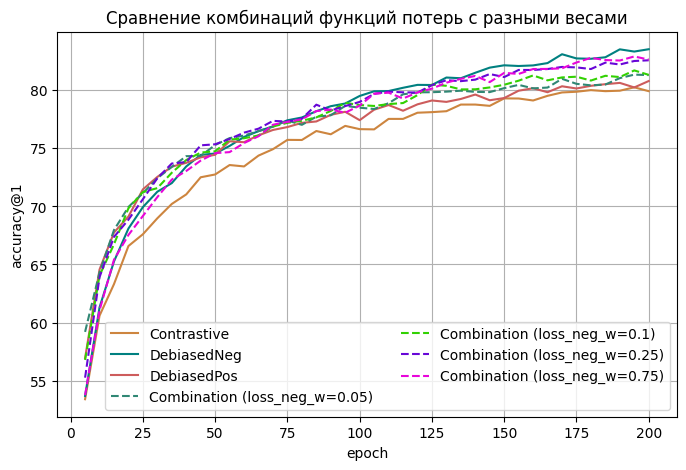

In [55]:
random.seed(42)
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df.sort_values('loss_neg_w').iterrows():
    m = get_metrics(row["uuid"])
    if len(m):
        w = row["loss_neg_w"]
        c = "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])
        plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + f" (loss_neg_w={w})", color=c, linestyle="--")

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение комбинаций функций потерь с разными весами")
plt.grid()
plt.savefig("images/exp_base_vs_combination.png", bbox_inches="tight")
plt.show()

## Эксперимент: base VS bs=256
Сравниваем все лоссы. Ожидаем, что при большем bs метрики лучше. Хотим посмотреть, как изменится ранжирование лоссов при новом параметре.

In [56]:
new_dict = base_dict.copy()
new_dict["batch_size"] = 256

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,lr,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,loss_neg_w,m_agg_mode,noise_frac,feature_dim,temperature,weight_decay
28,200,0.001,Contrastive,82eefce6-cbf5-4d9e-b410-46ea27bb572f,resnet50,200,CIFAR10,False,1,0.1,256,0.0,loss_combination,0.0,128,0.5,0.000001
29,200,0.001,DebiasedNeg,e0c2f57e-bf0c-40d0-b6aa-cf0c752fc55d,resnet50,200,CIFAR10,False,1,0.1,256,0.0,loss_combination,0.0,128,0.5,0.000001
30,200,0.001,DebiasedPos,9572d8e9-6496-4ef3-a85c-08525d56eae6,resnet50,200,CIFAR10,False,1,0.1,256,0.0,loss_combination,0.0,128,0.5,0.000001


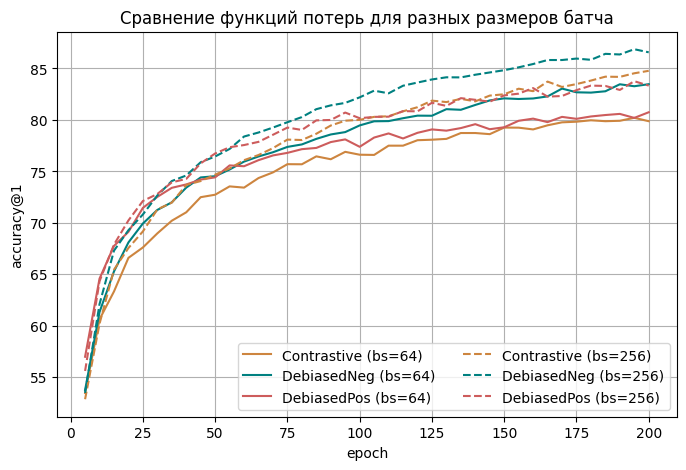

In [57]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (bs=64)", color=colors_map[row["loss"]])

for i, row in new_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (bs=256)", color=colors_map[row["loss"]], linestyle="--")

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь для разных размеров батча")
plt.grid()
plt.savefig("images/exp_base_vs_bs256.png", bbox_inches="tight")
plt.show()

Увеличение размера батча очевидно улучшает качество. Ранжирование лоссов в базовом эксперименте при этом не меняется